In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [32]:
MAX_EXP_THRESHOLD = 3.0
HISTOGRAM_THRESHOLD = 2.0

ANTIMERES = ['13-23', '14-24', '15-25', '16-26', '17-27',\
            '33-43', '34-44', '35-45', '36-46', '37-47']

MEASURE_TYPES = ['.cc', '.ctd', '.ct', '.gm']
measure_type_dict = {
    '.cc':'ClinCheck',
    '.ctd':'Centroid',
    '.ct':'Cusp Tip',
    '.gm': 'Gingival Margin'
}

In [ ]:
df = pd.read_csv("cases.csv",index_col="Patient ID", skiprows=1)

# removing all cases with maximum predicted expansion below threshold
df = df[(df['Max(4,5,6) Mx Exp'] >= MAX_EXP_THRESHOLD) & (df['Include?'] == 'Y')]

In [3]:
def percentAccuracy(row, antimere, measure_type):
    '''Given a row with "xx-xxi", "xx-xxp", "xx-xxf" columns for
    initial, predicted, and final arch widths across antimeres
    "xx-xx" (e.g. 13-23), returns the % of predicted expansion achieved.
    
    Antimere must be in the form '1x-2x' or '3x-4x'
    
    These antimeres also have suffix measure_type that is
    .cc, .ctd, .ct, .gm depending on how they were measured
    (ClinCheck archwidth, centroid, cusp tip, gingival margin)
    
    Note that is technically NOT accuracy, since
    if f > p, then 'accuracy' will be >100%.
    It is better described as % of predicted expansion achieved.

    Returns None if predicted expansion = 0'''
    
    predWidth = row[antimere+'p'+measure_type]
    achWidth = row[antimere+'f'+measure_type]
    initWidth = row[antimere+'i'+measure_type]
    
    predExp =  predWidth - initWidth
    achExp =  achWidth - initWidth
    
    if 0 in [predExp, predWidth, achWidth, initWidth]:
        return None
    return 100*achExp/predExp

def predictedExp(row, antimere, measure_type):
    '''Returns predicted expansion for a given row, antimere, measure type'''
    predWidth = row[antimere+'p'+measure_type]
    initWidth = row[antimere+'i'+measure_type]
    if predWidth == 0 or initWidth == 0:
        return None
    # assert(predWidth != initWidth)
    return predWidth - initWidth

def achievedExp(row, antimere, measure_type):
    '''Returns predicted expansion for a given row, antimere, measure type'''
    achWidth = row[antimere+'f'+measure_type]
    initWidth = row[antimere+'i'+measure_type]
    if initWidth == 0 or achWidth == 0:
        return None
    # assert(predWidth != initWidth)
    return achWidth - initWidth

def getColumn(df, column_name, antimere, threshold, measure_type, aligner_material):
    '''Returns Series of specified parameters.
    NB: If no threshold desired, set threshold = False, NOT threshold = 0.'''
    
    if aligner_material != False:
        df = df[df['Aligner Material'] == aligner_material]
    if type(threshold) == bool and threshold == False:
        return df[column_name]
    return df[df['pΔ%s%s' % (antimere, measure_type)] > threshold][column_name]

In [4]:
'''Data cleaning & processing; see comments.'''
for antimere in ANTIMERES:
    # Ensure all xx-xxipf columns are type float
    for measure_type in MEASURE_TYPES:
        if measure_type == '.cc' and '7' in antimere:
            continue

        df[antimere+'i'+measure_type].astype(float)
        df[antimere+'p'+measure_type].astype(float)
        df[antimere+'f'+measure_type].astype(float)

        # Create 'xx-xx %acc' column for each antimere
        full_antimere = antimere + measure_type
        df['%s %%acc' % full_antimere] = df.apply(lambda row: percentAccuracy(row, antimere, measure_type), axis=1)

        # Create 'pΔxx-xx.xx' & 'aΔxx-xx.xx' column for each antimere/measure type
        df['pΔ%s' % full_antimere] = df.apply(lambda row: predictedExp(row, antimere, measure_type), axis=1)
        df['aΔ%s' % full_antimere] = df.apply(lambda row: achievedExp(row, antimere, measure_type), axis=1)


In [5]:
# Plot histogram of %accuracy for each antimere        

def plotHistograms(df, aligner_material, measure_type):
    '''Plots histogram & outputs .PDF for a given
    aligner_material (EX30 or LD30) and
    measure_type (.cc, .ctd, .ct, or .gm)
    
    df should be filtered for cases passing threshold
    ONLY (i.e. df)
    '''
    
    pp = PdfPages('output/%s%s-histograms.pdf' % (aligner_material, measure_type))

    for antimere in ANTIMERES:
        if measure_type == '.cc' and '7' in antimere:
            continue
        full_antimere = antimere+measure_type

        f = plt.figure()

        plt.subplot(1, 2, 1)

        col1 = getColumn(df, '%s %%acc' % full_antimere, antimere, False, measure_type, aligner_material).dropna()            
        col1.hist(bins=10, facecolor='blue')
        plt.title('%s %s\n%%acc\nmean=%s\nn=%s' % (aligner_material, full_antimere, col1.mean(), len(col1)))

        plt.xlabel('% Accuracy')
        plt.ylabel('Frequency')

        # Plot histogram of %accuracy > HISTOGRAM_THRESHOLD for each antimere
        plt.subplot(1, 2, 2)

        col2 = getColumn(df, '%s %%acc' % full_antimere, antimere, HISTOGRAM_THRESHOLD, measure_type, aligner_material).dropna()            
        col2.hist(bins=10, facecolor='green')
        plt.title('%s %s\n%%acc when predExp > %s mm\nmean=%s\nn=%s' % (aligner_material, full_antimere, HISTOGRAM_THRESHOLD, col2.mean(), len(col2)))

        plt.xlabel('% Accuracy')
        plt.ylabel('Frequency')

        pp.savefig(f, bbox_inches="tight")
        plt.show()
    pp.close()

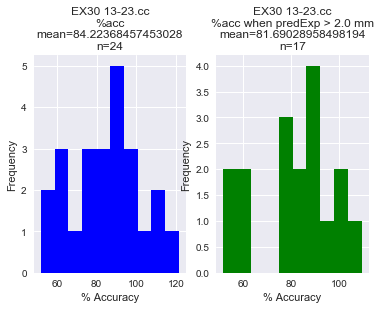

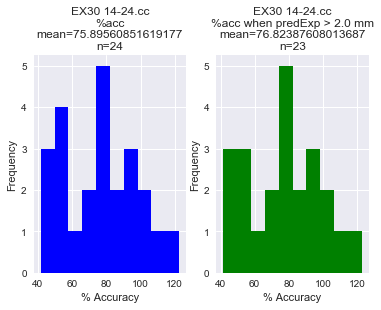

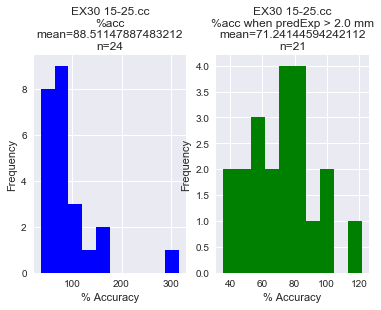

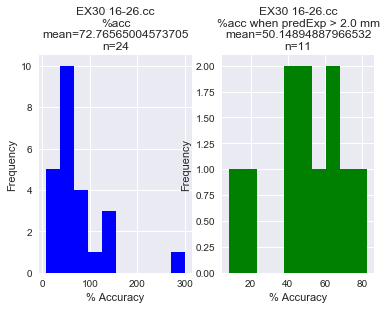

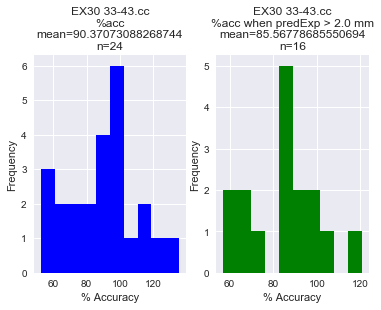

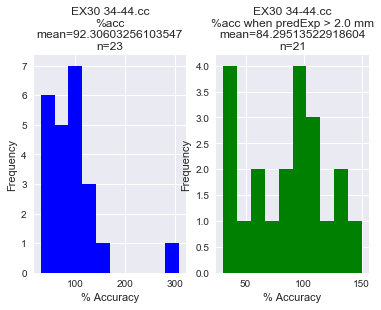

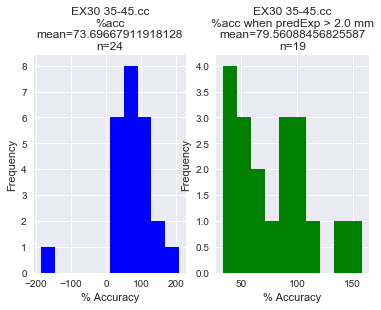

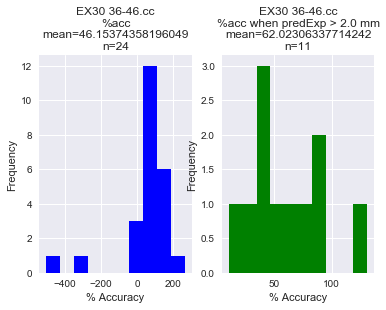

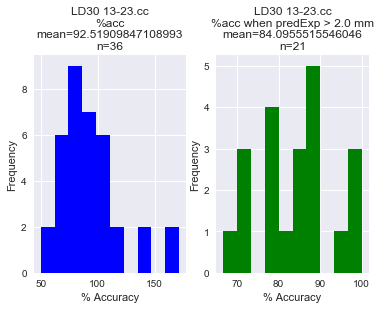

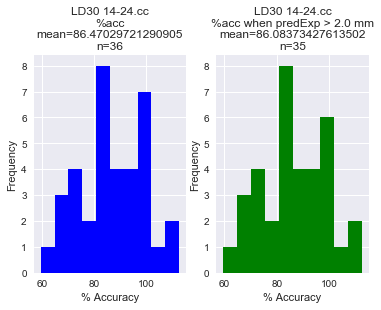

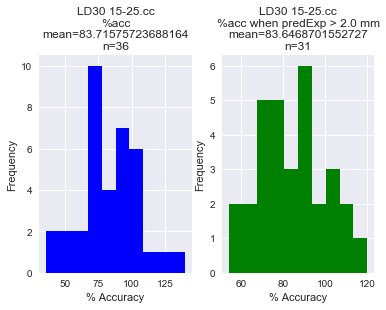

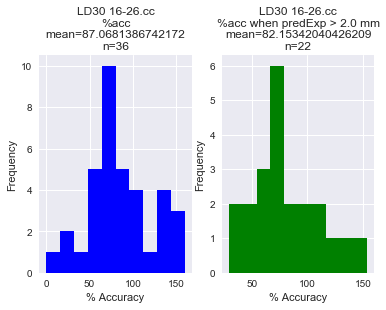

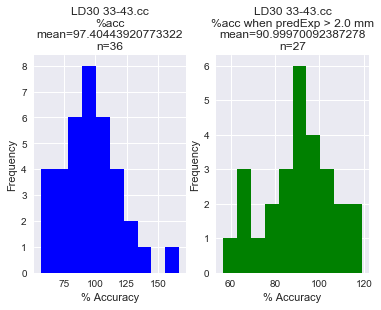

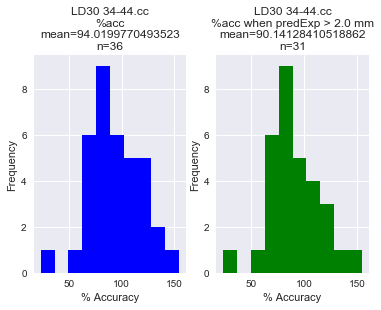

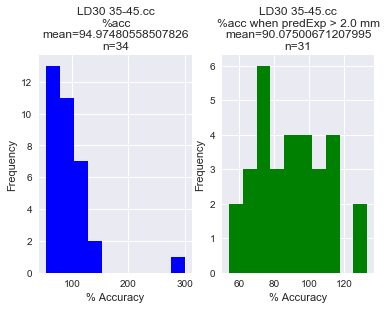

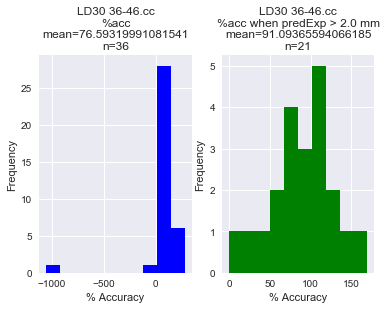

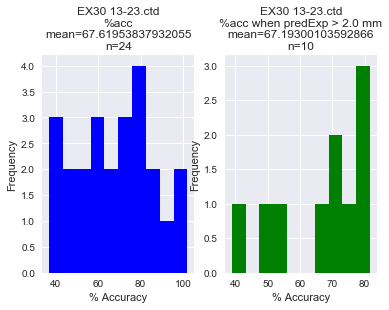

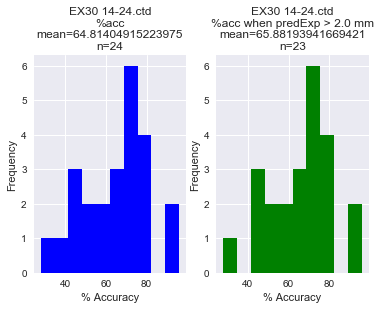

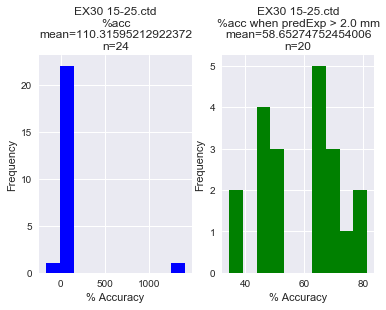

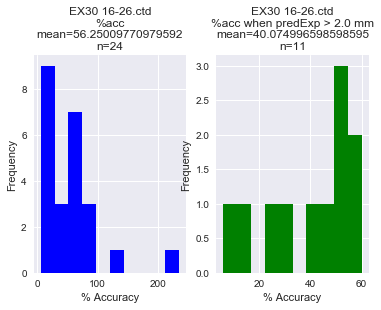

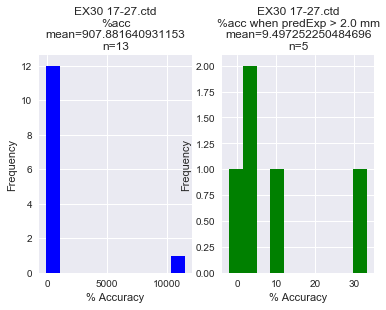

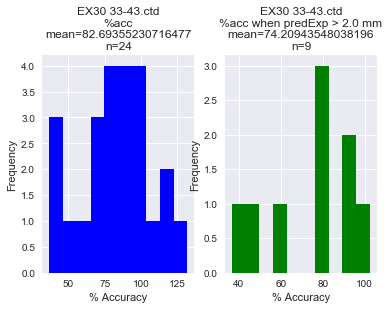

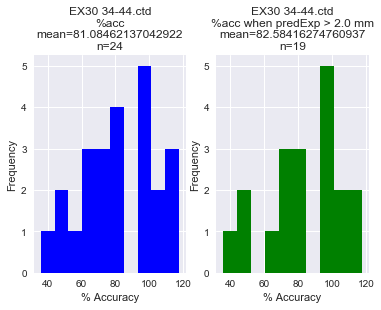

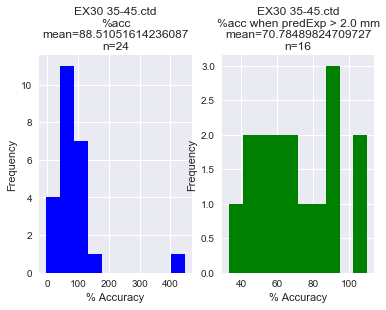

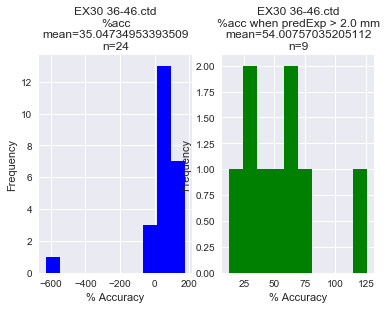

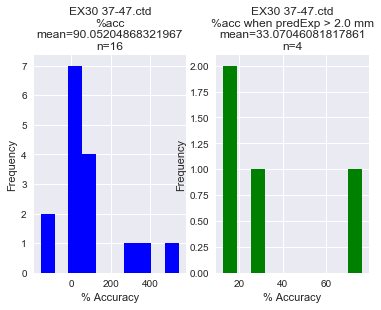

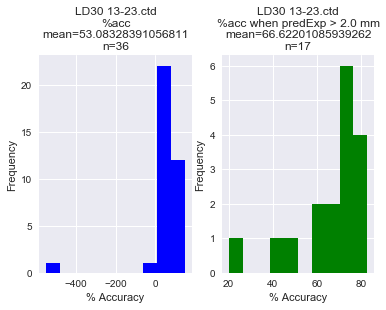

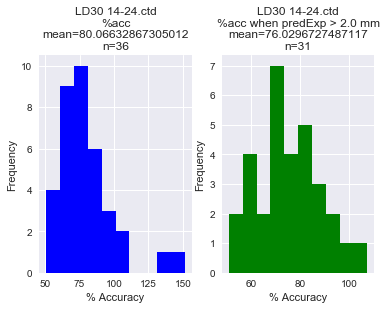

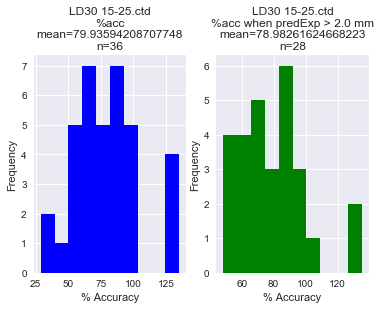

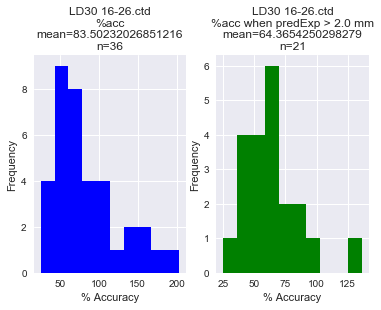

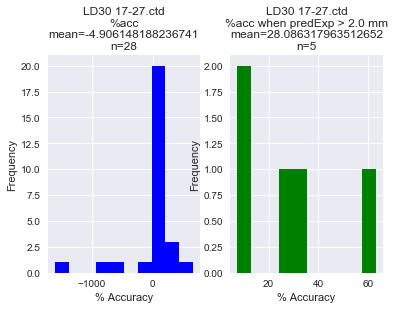

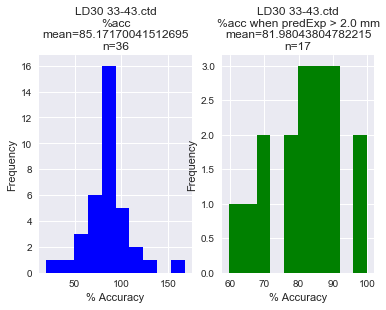

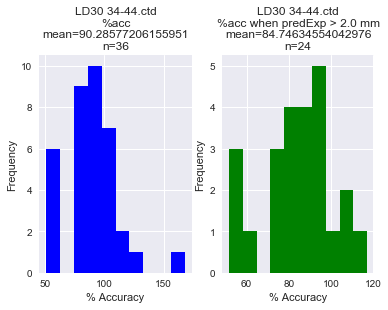

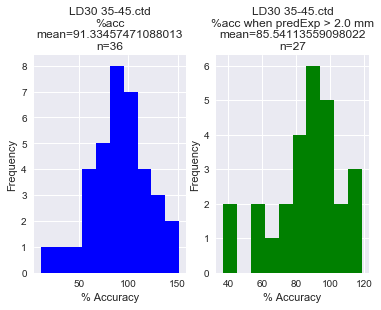

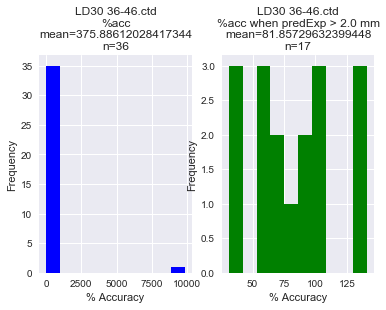

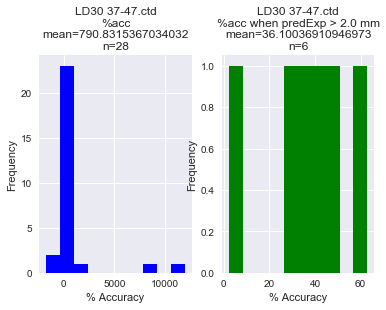

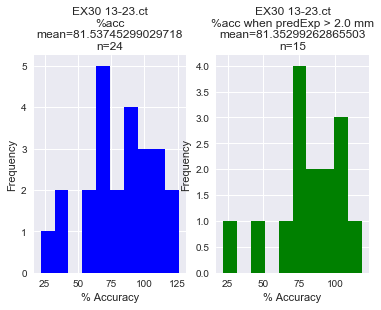

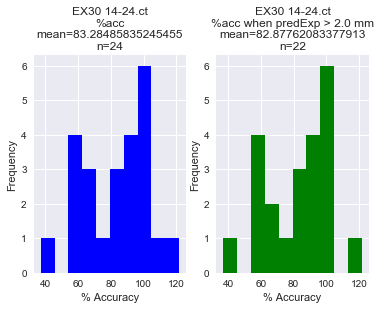

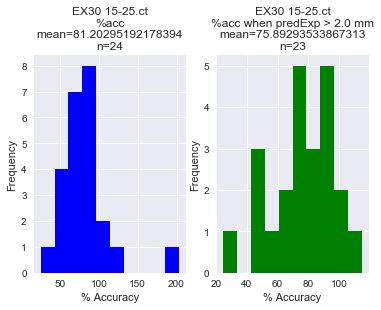

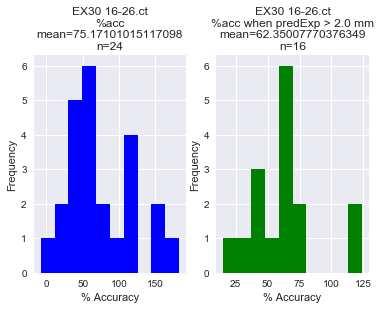

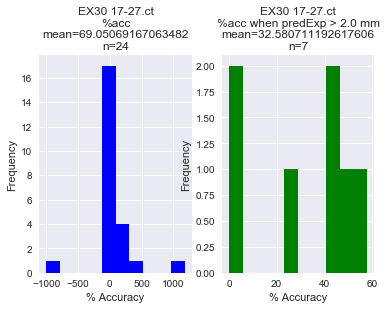

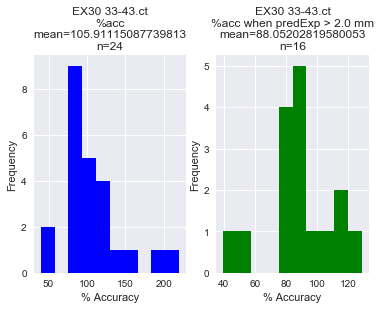

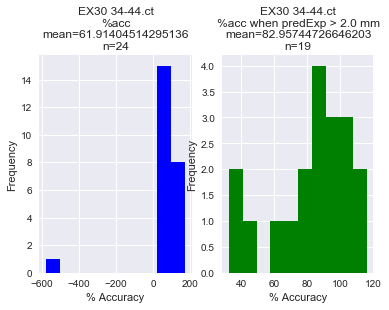

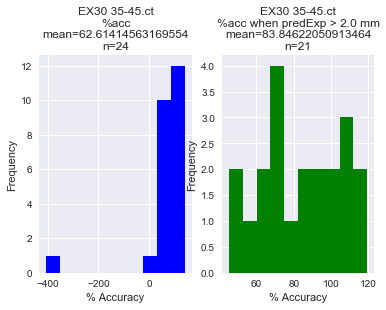

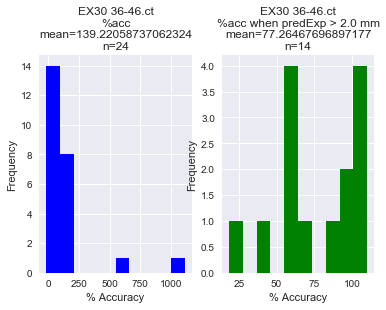

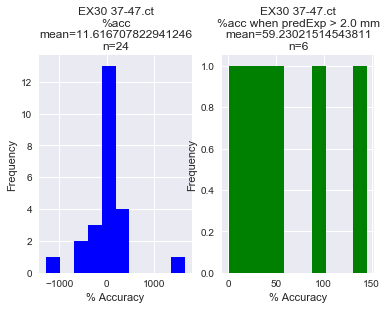

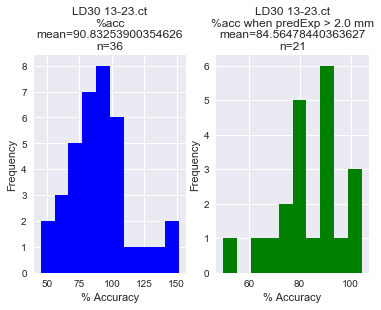

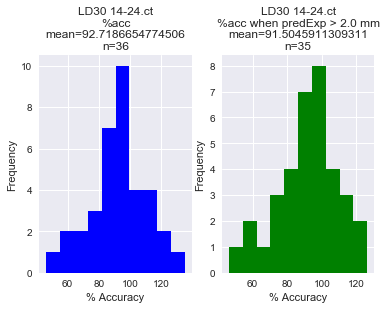

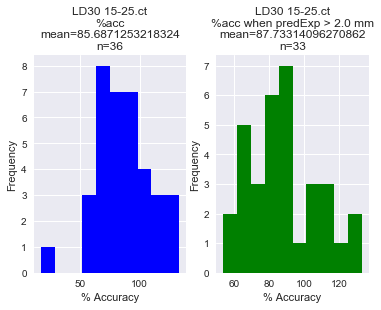

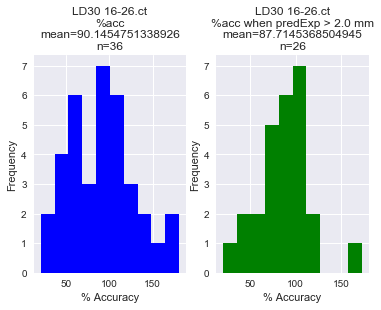

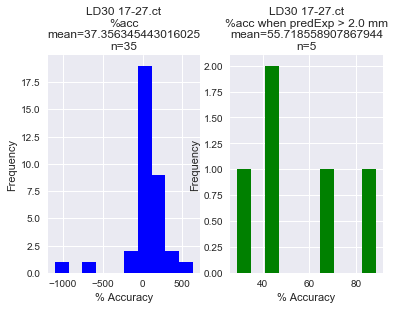

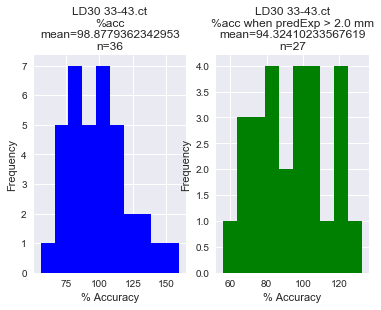

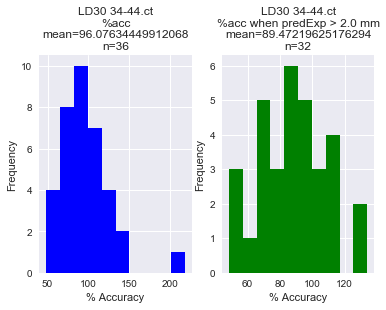

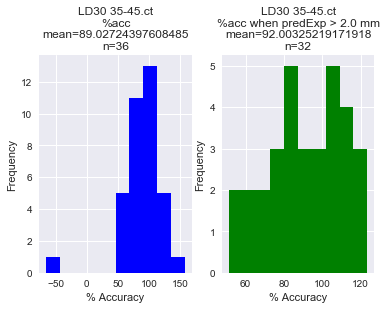

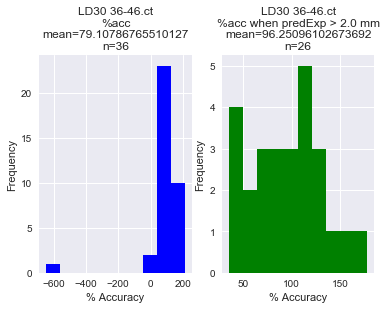

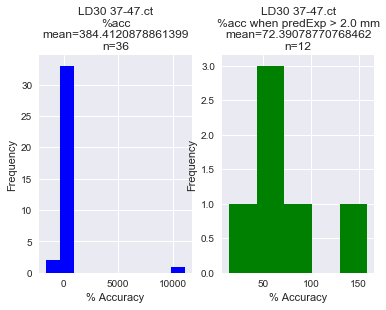

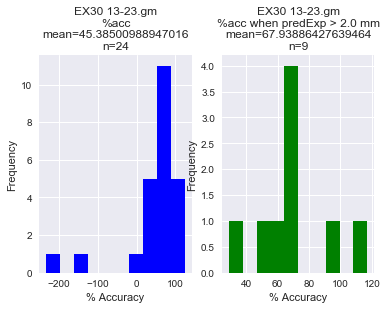

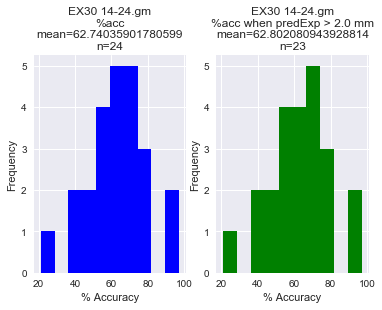

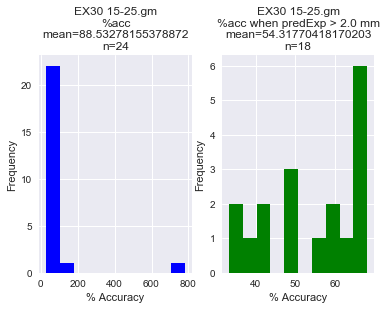

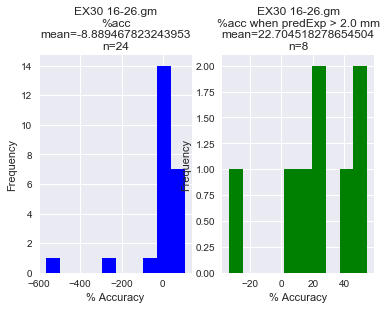

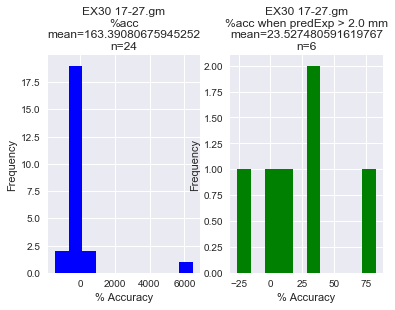

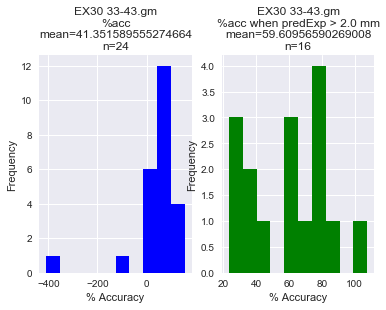

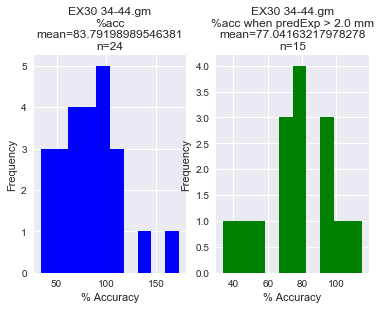

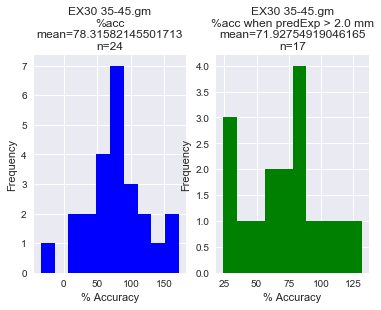

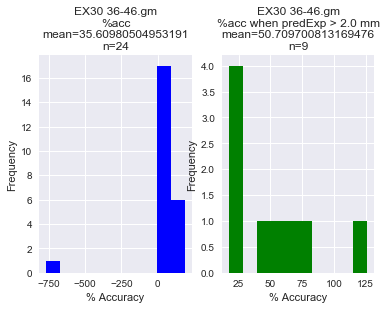

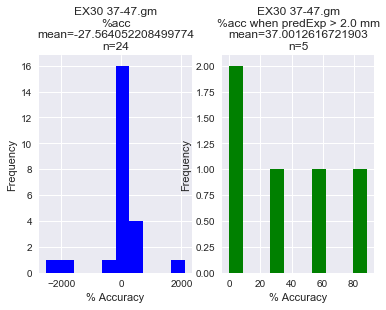

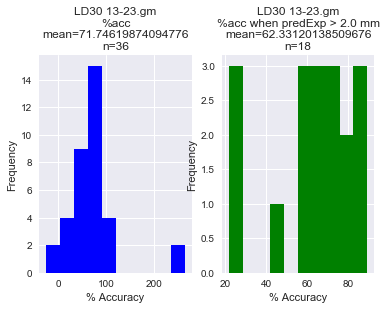

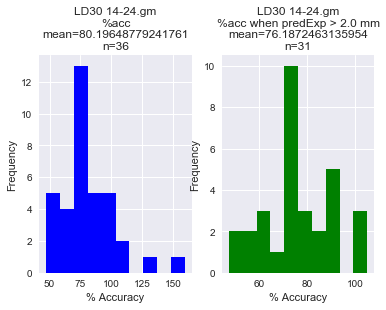

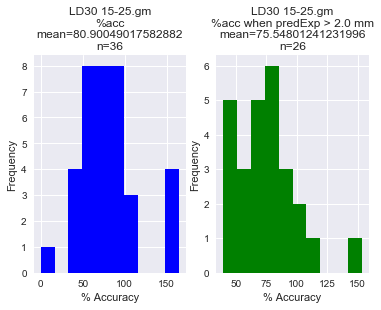

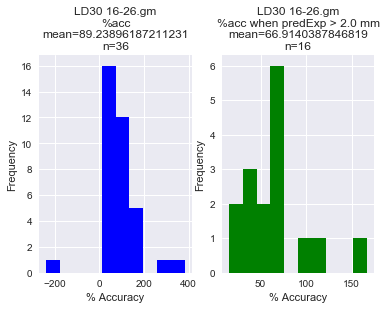

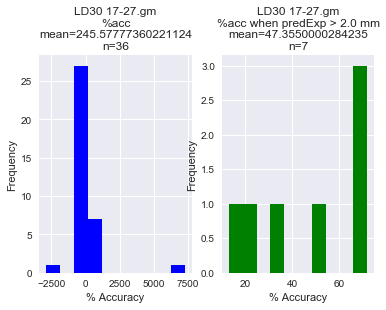

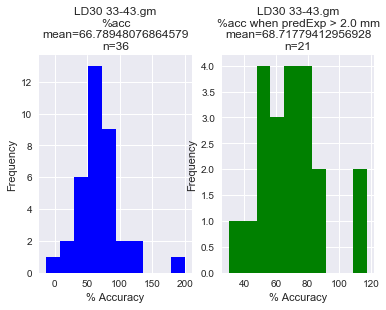

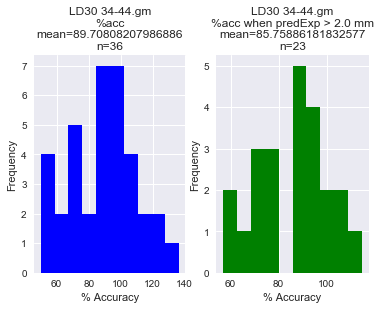

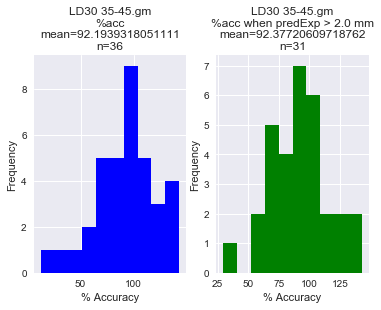

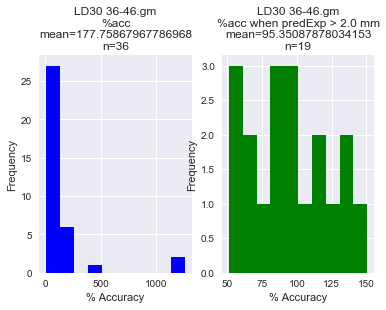

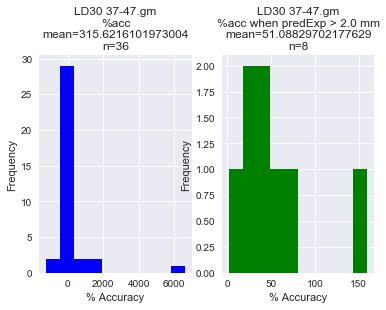

In [6]:
LD30 = df[df['Aligner Material'] == 'LD30']
EX30 = df[df['Aligner Material'] == 'EX30']

for measure_type in MEASURE_TYPES:
    plotHistograms(df, 'EX30', measure_type)
    plotHistograms(df, 'LD30', measure_type)

In [7]:
def printMeanAccuracies(df):

    print(LD30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].mean())
    print(LD30[['13-23.ctd %acc', '14-24.ctd %acc', '15-25.ctd %acc', '16-26.ctd %acc']].mean())
    print(EX30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].mean())
    print(EX30[['13-23.ctd %acc', '14-24.ctd %acc', '15-25.ctd %acc', '16-26.ctd %acc']].mean())

printMeanAccuracies(df)

13-23.cc %acc    92.519098
14-24.cc %acc    86.470297
15-25.cc %acc    83.715757
16-26.cc %acc    87.068139
dtype: float64
13-23.ctd %acc    53.083284
14-24.ctd %acc    80.066329
15-25.ctd %acc    79.935942
16-26.ctd %acc    83.502320
dtype: float64
13-23.cc %acc    84.223685
14-24.cc %acc    75.895609
15-25.cc %acc    88.511479
16-26.cc %acc    72.765650
dtype: float64
13-23.ctd %acc     67.619538
14-24.ctd %acc     64.814049
15-25.ctd %acc    110.315952
16-26.ctd %acc     56.250098
dtype: float64


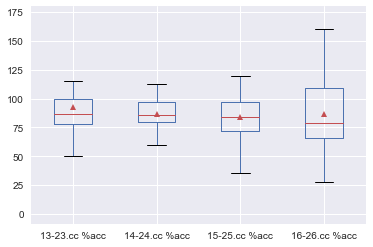

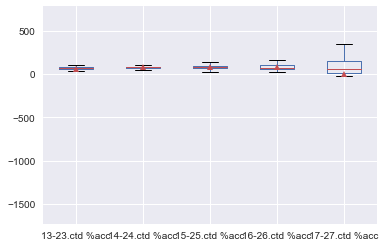

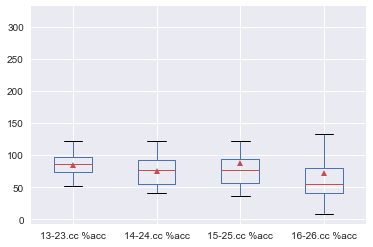

In [8]:
def boxPlots():
    LD30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].plot.box(showmeans=True)
    LD30[['13-23.ctd %acc', '14-24.ctd %acc', '15-25.ctd %acc', '16-26.ctd %acc', '17-27.ctd %acc']].plot.box(showmeans=True)
    EX30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].plot.box(showmeans=True)
    # EX30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].plot.hist(alpha=0.5, stacked=True)
boxPlots()

In [9]:
def compare_ex30_vs_ld30(measure_type, threshold):
    '''Prints statistical analysis comparing %acc of EX30 vs LD30 for a
    given measure_type and minimum expansion threshold'''
    
    if threshold:
        print("Is the %%accuracy of EX30 significantly different to LD30, when requested expansion > %s mm?\n" % threshold)
    else:
        print("Is the %%accuracy of EX30 significantly different to LD30, for any level of requested expansion?")

    all_ex30 = pd.Series([])
    all_ld30 = pd.Series([])
    
    for i, j in zip([1, 3], [2, 4]):
        for toothNum in range(3, 8):
            if measure_type == '.cc' and toothNum == 7:
                continue

            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s' % (i, toothNum, j, toothNum, measure_type)

            col1 = getColumn(df, '%s %%acc' % full_antimere, antimere, threshold, measure_type, 'EX30')            
            col2 = getColumn(df, '%s %%acc' % full_antimere, antimere, threshold, measure_type, 'LD30')
            stat, p = stats.ttest_ind(col1, col2, nan_policy='omit')

            print('---%s---' % full_antimere)
            print('EX30: mean=%s\tstd=%s\tn=%s' % (col1.mean(), col1.std(), col1.count()))
            print('LD30: mean=%s\tstd=%s\tn=%s' % (col2.mean(), col2.std(), col2.count()))
            s = 'p=%s' % p
            if p < 0.05:
                s = '*' + s
            print('%s\n' % s)
            
            all_ex30 = all_ex30.append(col1)
            all_ld30 = all_ld30.append(col2)
    
    stat, p = stats.ttest_ind(all_ex30, all_ld30, nan_policy='omit')
    print('ALL EX30%s: mean=%s\tstd=%s\tn=%s' % (measure_type, all_ex30.mean(), all_ex30.std(), all_ex30.count()))
    print('ALL LD30%s: mean=%s\tstd=%s\tn=%s' % (measure_type, all_ld30.mean(), all_ld30.std(), all_ld30.count()))
    
    s = 'p=%s' % p
    if p < 0.05:
        s = '*' + s
    print('%s\n\n\n' % s)
    
    return

for measure_type in MEASURE_TYPES:
    compare_ex30_vs_ld30(measure_type, HISTOGRAM_THRESHOLD)
    compare_ex30_vs_ld30(measure_type, False)

Is the %accuracy of EX30 significantly different to LD30, when requested expansion > 2.0 mm?

---13-23.cc---
EX30: mean=81.69028958498194	std=16.986925080920965	n=17
LD30: mean=84.0955515546046	std=9.750861345509202	n=21
p=0.587157787286

---14-24.cc---
EX30: mean=76.82387608013687	std=22.907037066653157	n=23
LD30: mean=86.08373427613502	std=12.477336386084032	n=35
p=0.0515377029859

---15-25.cc---
EX30: mean=71.24144594242112	std=21.680812459615094	n=21
LD30: mean=83.6468701552727	std=16.331908031557376	n=31
*p=0.0226121478146

---16-26.cc---
EX30: mean=50.14894887966532	std=22.37343344414332	n=11
LD30: mean=82.15342040426209	std=29.940948111123173	n=22
*p=0.00383424782616

---33-43.cc---
EX30: mean=85.56778685550694	std=17.036260756349204	n=16
LD30: mean=90.99970092387278	std=15.95563470448671	n=27
p=0.298761857387

---34-44.cc---
EX30: mean=84.29513522918604	std=33.632751295133815	n=21
LD30: mean=90.14128410518862	std=25.667500608097154	n=31
p=0.480736522499

---35-45.cc---
EX30: me

In [10]:
def compare_predicted_vs_achieved(material, measure_type, threshold):
    '''Prints statistical analysis comparing %acc of  vs LD30 for a
    given measure_type and minimum expansion threshold'''
    
    assert(material in ['LD30', 'EX30'])
    
    if threshold:
        print("Is the actual expansion of %s significantly different to its predicted expansion, for cases where predicted expansion >%s mm?\n"\
          % (material, threshold))
    else:
        print("Is the actual expansion of %s significantly different to its predicted expansion, for any level of predicted expansion?\n"\
          % (material))
    
    for i, j in zip([1, 3], [2, 4]):
        for toothNum in range(3, 8):
            if measure_type == '.cc' and toothNum == 7:
                continue

            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s' % (i, toothNum, j, toothNum, measure_type)

            col1 = getColumn(df, '%sf%s' % (antimere, measure_type), antimere, threshold, measure_type, material)
            col2 = getColumn(df, '%sp%s' % (antimere, measure_type), antimere, threshold, measure_type, material)
            stat, p = stats.ttest_rel(col1, col2, nan_policy='omit')

            print('---%s---' % full_antimere)
            s = 'p=%s' % p
            if p < 0.05:
                s = '*' + s
            print('%s\tn=%s\n' % (s, col1.count()))
    return

for measure_type in MEASURE_TYPES:
    compare_predicted_vs_achieved('LD30', measure_type, False)

Is the actual expansion of LD30 significantly different to its predicted expansion, for any level of predicted expansion?

---13-23.cc---
*p=0.00597607487109	n=36

---14-24.cc---
*p=5.75073337538e-07	n=36

---15-25.cc---
*p=3.20637143392e-06	n=36

---16-26.cc---
*p=0.00775608135966	n=36

---33-43.cc---
*p=0.0200875313639	n=36

---34-44.cc---
p=0.0773204265074	n=36

---35-45.cc---
*p=0.00218411391909	n=34

---36-46.cc---
p=0.416287802408	n=36

Is the actual expansion of LD30 significantly different to its predicted expansion, for any level of predicted expansion?

---13-23.ctd---
*p=1.77658880144e-09	n=36

---14-24.ctd---
*p=1.88928091287e-08	n=36

---15-25.ctd---
*p=4.53621240251e-06	n=36

---16-26.ctd---
*p=0.000517704553711	n=36

---17-27.ctd---
p=0.561418533703	n=36

---33-43.ctd---
*p=1.13184211543e-05	n=36

---34-44.ctd---
*p=0.000443317118496	n=36

---35-45.ctd---
*p=0.00636076098326	n=36

---36-46.ctd---
p=0.159427800052	n=36

---37-47.ctd---
p=0.195842190185	n=36

Is the actual

In [11]:
def getSubDf(df, measure_type, threshold, aligner_material):
    '''Returns a df with specified measure_type, aligner_material, and
    above predicted expansion threshold only'''
    cols = []
    for antimere in ANTIMERES:
        if measure_type == '.cc' and '7' in antimere:
            continue
        col = getColumn(df, '%s%s %%acc' % (antimere, measure_type), antimere, threshold, measure_type, aligner_material)    
        cols.append(col)
    return pd.concat(cols, axis=1)

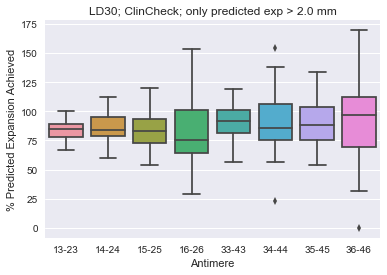

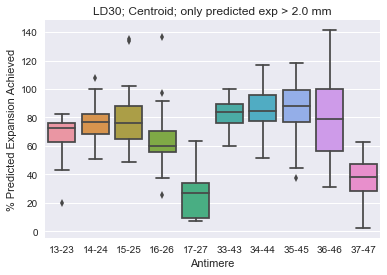

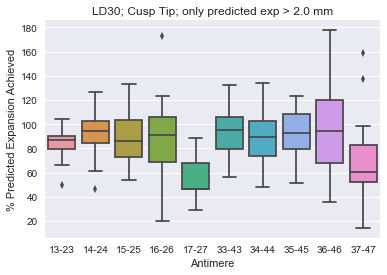

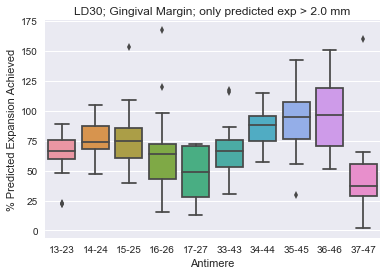

In [41]:
def boxPlot(df, measure_type, threshold, material):
    subDf = getSubDf(df, measure_type, HISTOGRAM_THRESHOLD, 'LD30')
    subDf = subDf.rename(columns = lambda x : str(x)[:5])
    
    bplot = sns.boxplot(data=subDf)
    bplot.axes.set_title("%s; %s; only predicted exp > %s mm" % (material, measure_type_dict[measure_type], threshold))
    bplot.set_xlabel("Antimere")
    bplot.set_ylabel("% Predicted Expansion Achieved")
    
    plt.show(sns)
    
for measure_type in MEASURE_TYPES:
    boxPlot(df, measure_type, HISTOGRAM_THRESHOLD, 'LD30')

In [13]:
df.head()

,Treatment Start Date,Aligner Material,Patient Name,Treatment Type,Patient Age,Include?,"Max(4,5,6) Mx Exp","Avg(4,5,6) Exp",13-23i.cc,13-23p.cc,...,aΔ36-46.gm,37-47.ctd %acc,pΔ37-47.ctd,aΔ37-47.ctd,37-47.ct %acc,pΔ37-47.ct,aΔ37-47.ct,37-47.gm %acc,pΔ37-47.gm,aΔ37-47.gm
Patient ID,,,,,,,,,,,,,,,,,,,,,
1645196,16/2/10,EX30,"M, Lauren",FULL,29,Y,3.6,2.833333333,30.1,34.4,...,0.72,NaN,0.000000,-0.498632,-346.153846,0.13,-0.45,-500.000000,0.02,-0.10
1654114,25/2/10,EX30,"S, Michelle",FULL,34,Y,4.4,3.333333333,32.4,35.7,...,1.06,373.177317,0.274662,1.024974,275.000000,1.04,2.86,407.692308,0.13,0.53
1776637,12/7/10,EX30,"M, Keysha",FULL,33,Y,4.5,3,31.4,33.5,...,1.50,547.954530,0.132185,0.724315,1645.454545,0.11,1.81,427.027027,0.37,1.58
1809618,23/8/10,EX30,"V, Deenal",FULL,25,Y,3.5,2.466666667,30.2,32.7,...,0.98,77.163831,0.390525,0.301344,255.555556,0.18,0.46,-30.303030,0.33,-0.10
1812712,25/8/10,EX30,"T, Phillip",FULL,27,Y,3.2,2.633333333,33.7,36.6,...,0.61,18.074618,1.971684,0.356374,73.913043,1.84,1.36,-47.286822,1.29,-0.61


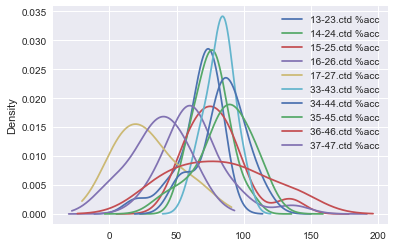

In [14]:
getSubDf(df, '.ctd', HISTOGRAM_THRESHOLD, 'LD30').plot.kde()

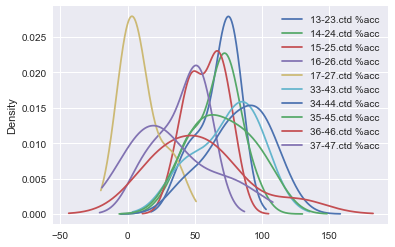

In [15]:
getSubDf(df, '.ctd', HISTOGRAM_THRESHOLD, 'EX30').plot.kde()

{'boxes': [<matplotlib.lines.Line2D at 0x11d5abc50>,
 'caps': [<matplotlib.lines.Line2D at 0x10ebbea90>,
 'fliers': [<matplotlib.lines.Line2D at 0x119cd0cf8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10ec015f8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x11d5ab128>,
  <matplotlib.lines.Line2D at 0x119e47780>]}

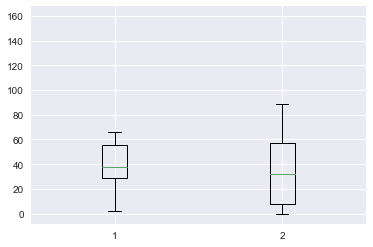

In [16]:
a = getColumn(df, '37-47.gm %acc', '37-47', 2, '.gm', 'LD30')
b = getColumn(df, '37-47.gm %acc', '37-47', 2, '.gm', 'EX30')
plt.boxplot([a, b])

In [17]:
getColumn(df, '35-45.gm %acc', '35-45', 2, '.gm', 'LD30')

Patient ID
2952792    110.182768
2963992     68.064516
2987641    142.857143
3006227    101.893939
3120651    120.474777
3165818     29.583333
3182125     96.466431
3220134     94.140127
3223943    107.037037
3307283    101.587302
3328760     85.642317
3452431     95.165394
3481023     61.464968
3519570    127.572016
3538481    107.331378
3558898     71.521739
3721347    107.077626
3729943     80.677966
3791559     70.545455
3855283     73.411765
3897351    103.017241
3916320     55.290102
3970955    136.633663
3976052     81.385281
4027018    113.718412
4143745     93.871866
4151217     96.694215
4233296     78.750000
4393227     67.838313
4401903     87.500000
4519394     96.296296
Name: 35-45.gm %acc, dtype: float64